# Inference: First example

This example shows you how to perform Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc/adaptive_covariance_mcmc.html).

It follows on from [Optimisation: First example](./optimisation-first-example.ipynb)

Like in the optimisation example, we start by importing pints:

In [1]:
import pints

Next, we create a model class. 

Instead of using a real model, in this example we use the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, we choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, we can now generate some toy data:

In [5]:
org_values = model.simulate(true_parameters, times)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 25
values = org_values + np.random.normal(0, noise, org_values.shape)

We can use matplotlib (or any other plotting package) to look at the data we've created:

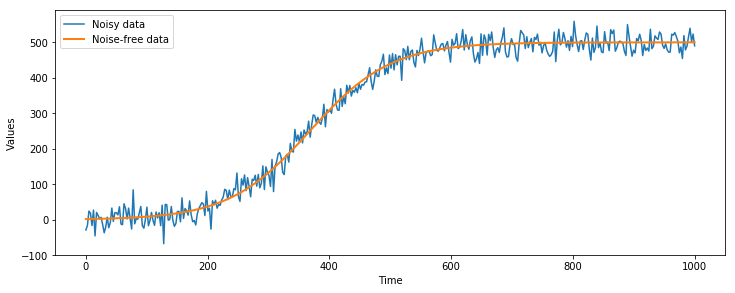

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now we have enough data (a model, a list of times, and a list of data) to formulate a problem:

In [8]:
problem = pints.SingleSeriesProblem(model, times, values)

We now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, we need to add a _noise model_. One way to do this is using the `UnknownNoiseLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

This noise has mean zero, and an unknown standard deviation. How can we find out the standard deviation? By inferring it along with the other parameters. This means we have added one parameter to our problem!

In [10]:
print('Original problem dimension: ' + str(problem.dimension()))

Original problem dimension: 2


In [11]:
print('New dimension: ' + str(log_likelihood.dimension()))

New dimension: 3


(This means we also have to update our vector of true parameters)

In [12]:
true_parameters += [noise]
print(true_parameters)

[0.015, 500, 25]


This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

We can use this in a Bayesian inference scheme to find the quantity we're interested in:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, we now define a _prior_, indicating our initial ideas about what the parameters should be. 
Just as we're using a _log-likelihood_ (the natural logarithm of a likelihood), we'll define this using a _log-prior_. This simplifies the above equation to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example we'll assume we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [13]:
log_prior = pints.UniformLogPrior(
    [0.01, 400, 1],
    [0.02, 600, 100]
    )

With this prior, we can now define the numerator of Bayes' rule -- the unnormalised log posterior, $\log p(\theta) + \log p(y|\theta)$:

In [14]:
log_posterior = pints.LogPosterior(log_prior, log_likelihood)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [15]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

And this gives us everything we need to run an MCMC routine:

In [16]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Adaptive covariance MCMC
Running in sequential mode.
0
1
2
3
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
2620
2640
2660
2680
2700
2720
2740
2760
2780
2800
2820
2840
2860
2880
2900
2920
2940
2960
2980
3000
3020
3040
3060
3080
3100
3120
3140
3160
3180
3200
3220
3240
3260
3280
3300
3320
3340
3360
3380
3400
3420
3440
3460
3480
3500
3520
3540
3560
3580
3600
3620
3640
3660
3680
3700
3720
3740
3760
3780
3800
3820
3840
3860
3880
3900
3920
3940
3

## Using Pints' diagnostic plots to inspect the results

We can take a further look at the obtained results using Pints's [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html).

First, we use the [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) method to see if the three chains converged to the same solution.

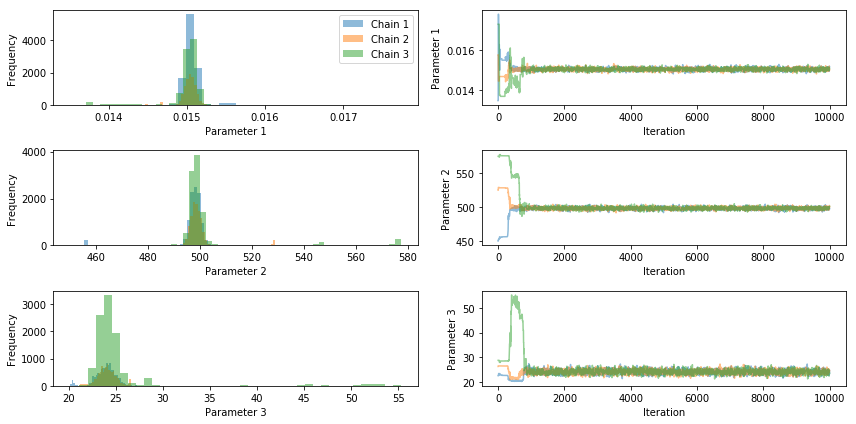

In [17]:
import pints.plot
pints.plot.trace(*chains)
plt.show()

Based on this plot, it looks like the three chains become very similar after about 1000 iterations.
To be safe, we throw away the first 2000 samples and continue our analysis with the first chain.

In [18]:
chain = chains[0]
chain = chain[2000:]

We can also look for autocorrelation in the chains, using the [autocorrelation()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation) method. If everything went well, the samples in the chain should be relatively independent, so the autocorrelation should get quite low when the `lag` on the x-axis increases.

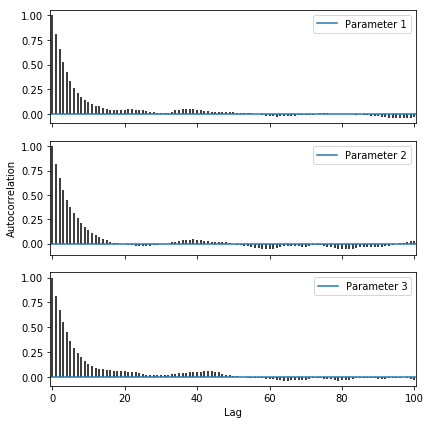

In [19]:
pints.plot.autocorrelation(chain)
plt.show()

Now we can inspect the inferred distribution by plotting histograms:

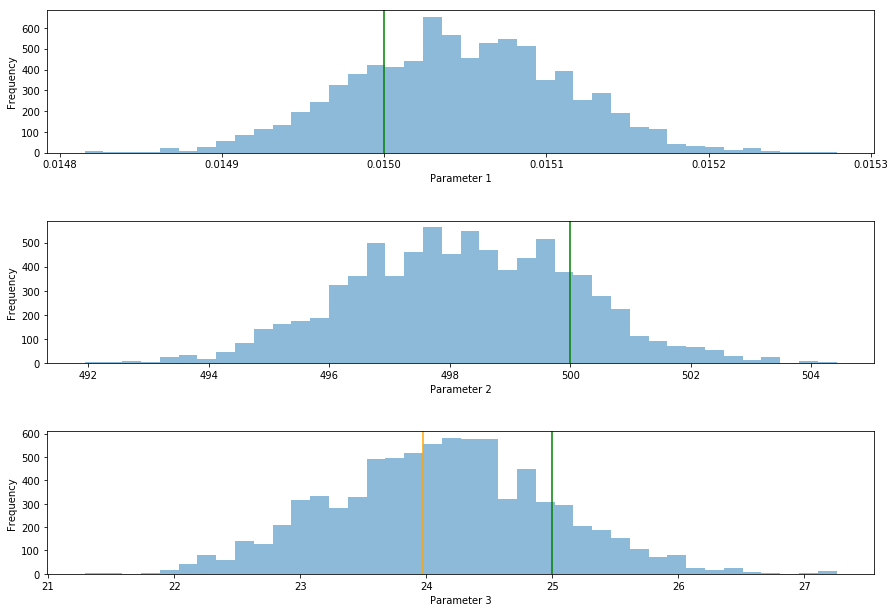

In [20]:
import pints.plot

fig, axes = pints.plot.histogram(chain)

# Show true value
for i, real in enumerate(true_parameters):
    axes[i].axvline(real, color='green')

# Show where the sample standard deviation of the generated noise is:
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)
axes[i].axvline(noise_sample_std, color='orange')

fig.set_size_inches(14, 9)
plt.show()

Here we've analysed each parameter in isolation, but we can also look at correlations between parameters we found using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

To speed things up, we'll first apply some _thinning_ to the chain:

In [25]:
chain = chain[::10]

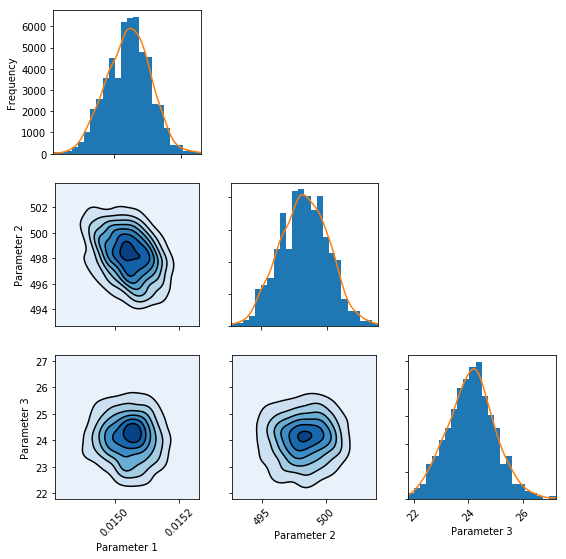

In [26]:
pints.plot.pairwise(chain, kde=True)
plt.show()

As these plots show, we came pretty close to the original "true" values (represented by the blue line). 
But not exactly... Worse, the method seems to suggest a normal distribution but around the wrong point.
To find out what's going on, we can plot the log-posterior function near the true parameters:

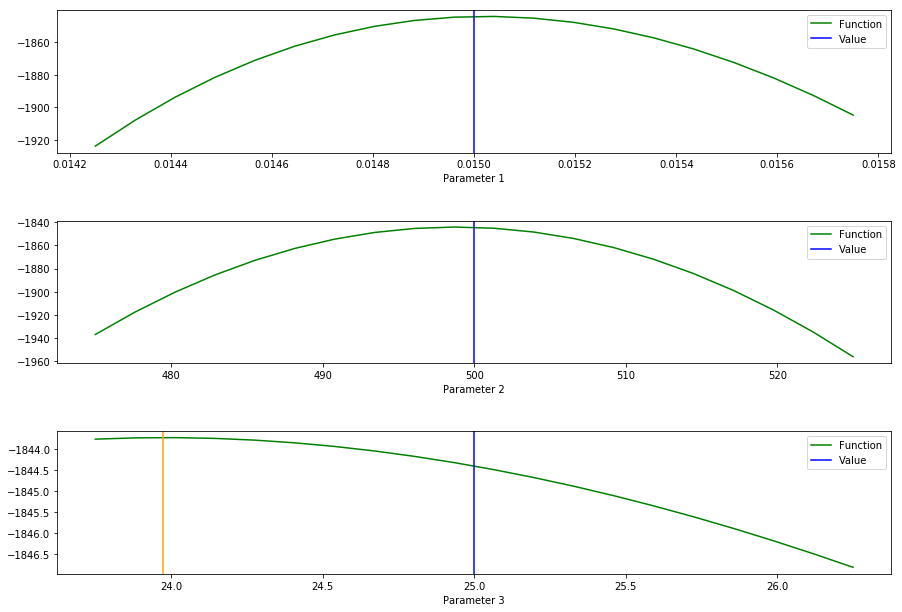

In [27]:
# Plot log-posterior function
fig, axes = pints.plot.function(log_posterior, true_parameters)

# Add a line showing the sample standard deviation of the generated noise
axes[-1].axvline(noise_sample_std, color='orange', label='Sample std.')

# Customise the figure size
fig.set_size_inches(14, 9)
plt.show()

As this plot (created entirely without MCMC!) shows, the MCMC method did well, but our estimate of the true parameters has become _biased_ by the stochastic noise! You can test this by increasing the number of sample points, which increases the size of the noise sample, and reduces the bias.

Finally, we can look at the bit that really matters: The model predictions made from models with the parameters we found (a _posterior predictive check_). Thes can be plotted using the [series()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.series) method.

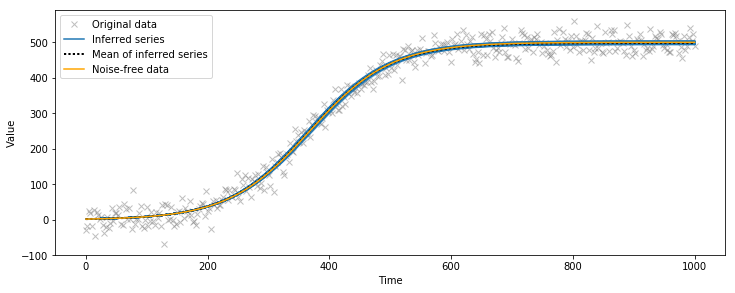

In [28]:
fig, axes = pints.plot.series(chain, problem)

# Customise the plot, and add the original, noise-free data
fig.set_size_inches(12,4.5)
plt.plot(times, org_values, c='orange', label='Noise-free data')
plt.legend()
plt.show()